# Playback with  `MPC dataset` and `Ground Truth`

In [2]:
import torch
import mujoco
import numpy as np
import matplotlib.pyplot as plt
from mujoco_parser import MuJoCoParserClass
from util import rpy2r, r2quat, r2rpy, quat2r
import pickle
import mediapy as media
from util import rpy2r,MultiSliderClass,create_folder_if_not_exists,slerp
import cv2,glob,os

from policy import GaussianPolicy

np.set_printoptions(precision=2,suppress=True,linewidth=100)
plt.rc('xtick',labelsize=6); plt.rc('ytick',labelsize=6)
%config InlineBackend.figure_format = 'retina'
# %matplotlib inline
print ("MuJoCo version:[%s]"%(mujoco.__version__))

/Users/yoonbyung/opt/anaconda3/envs/snapbot/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


MuJoCo version:[2.3.7]


### Load `Ground Truth`

In [3]:
with open(file='../data/smplrig_cmu_walk_optimized_interpolated.pkl', mode='rb') as f:
    GT = pickle.load(f)

print(GT.keys())
# GT Stand 

dict_keys(['action', 'qpos', 'qvel'])


In [4]:
def compute_reward(qpos0, qpos1, xpos0, xpos1, rot0, rot1, qvel0, qvel1):
    keypoint_idxs = [11, 35, 58, 61] # end effector pos :  left wrist, right wrist, left_ankle, right_ankle
    # rotation of a quaternion error
    rpy0 = np.array([r2rpy(rot) for rot in rot0])
    rpy1 = np.array([r2rpy(rot) for rot in rot1])
    rpy = rpy0 - rpy1
    rpy = np.sum(np.square(rpy))
    rpy = np.exp(-2*rpy)

    # angular velocity error
    qvel = qvel0 - qvel1
    qvel = np.sum(np.square(qvel))
    qvel = np.exp(-0.1*qvel)

    # key point task position error
    xpos = xpos0[keypoint_idxs, :] - xpos1[keypoint_idxs, :]
    xpos = np.sum(np.square(xpos))
    xpos = np.exp(-40*xpos)

    # COM error
    root_position = qpos0[...,:3] - qpos1[...,:3]
    root_position = np.sum(np.square(root_position))
    root_position = np.exp(-10*root_position)

    reward = root_position + qvel + rpy + xpos

    return reward, {"root_position": root_position, "rpy": rpy, "qvel": qvel, "xpos": xpos}
    # qpos = q0[...,7:] - q1[...,7:]
    # print(q0.shape, q1.shape)

def finite_difference_matrix(n, dt, order):
    """
    n: number of points
    dt: time interval
    order: (1=velocity, 2=acceleration, 3=jerk)
    """ 
    # Order
    if order == 1:  # velocity
        coeffs = np.array([-1, 1])
    elif order == 2:  # acceleration
        coeffs = np.array([1, -2, 1])
    elif order == 3:  # jerk
        coeffs = np.array([-1, 3, -3, 1])
    else:
        raise ValueError("Order must be 1, 2, or 3.")

    # Fill-in matrix
    mat = np.zeros((n, n))
    for i in range(n - order):
        for j, c in enumerate(coeffs):
            mat[i, i + j] = c
    return mat / (dt ** order)

def get_A_vel_acc_jerk(n=100,dt=1e-2):
    """
        Get matrices to compute velocities, accelerations, and jerks
    """
    A_vel  = finite_difference_matrix(n,dt,order=1)
    A_acc  = finite_difference_matrix(n,dt,order=2)
    A_jerk = finite_difference_matrix(n,dt,order=3)
    return A_vel,A_acc,A_jerk


In [4]:
# Ground-Truth

# A_vel,A_acc,A_jerk = get_A_vel_acc_jerk(n=GT['qpos'].shape[0],dt=1/500)
GT_qpos = np.concatenate((GT['p_root'], GT['R_root'], GT['qpos']), axis=1)
GT_qvel = np.concatenate((GT['v_root'], GT['w_root'], GT['qvel']), axis=1)
GT_xpos = GT['xpos']
GT_rotation = GT['rotation']

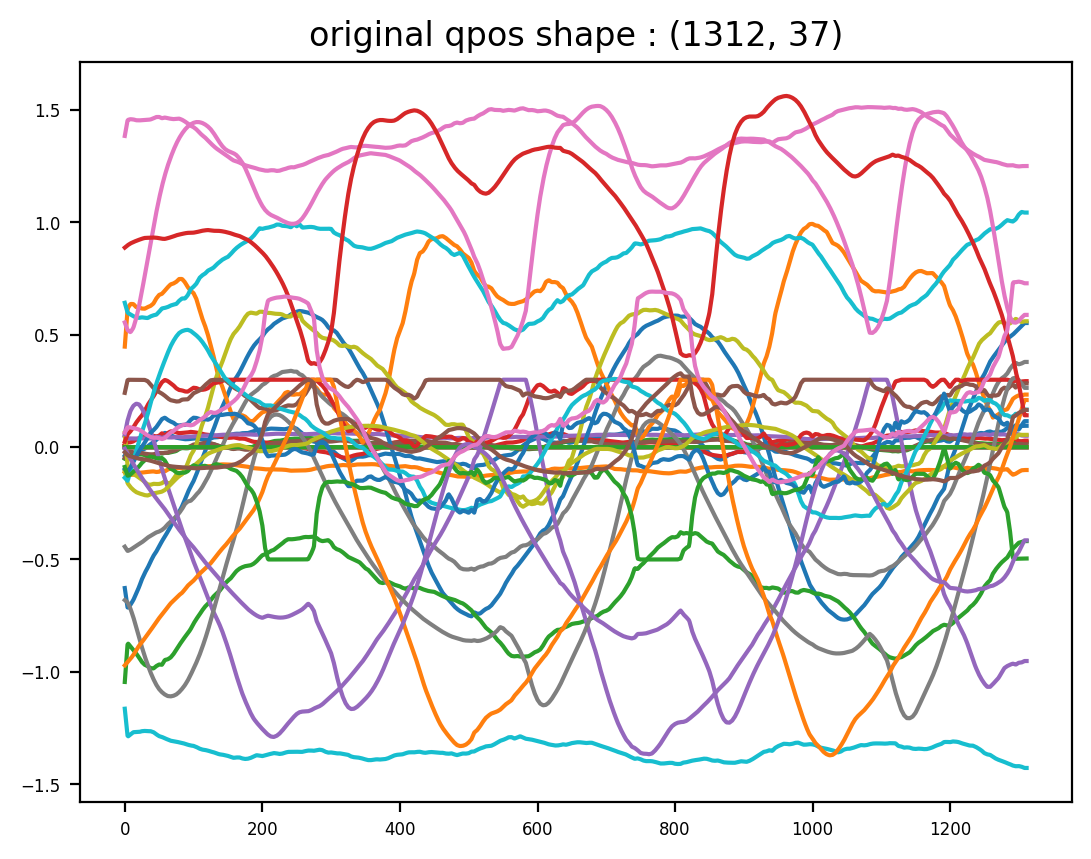

In [5]:
plt.figure()
plt.title("original qpos shape : {}".format(GT['qpos'].shape))
# print(GT['qpos'].shape, new_qpos.shape)
plt.plot(GT['qpos'])
plt.show()

### Load `MPC dataset`

In [10]:
with open(file='../data/smpl walk foot heuristic.pkl', mode='rb') as f:
    dataset = pickle.load(f)

horizon = 460

action_batch = np.array(dataset['action'])
qpos_batch = np.array(dataset['qpos'])
qvel_batch = np.array(dataset['qvel'])

action_batch = action_batch.reshape(action_batch.shape[0] * horizon, -1)
qpos_batch = qpos_batch.reshape(qpos_batch.shape[0] * horizon, -1)
qvel_batch = qvel_batch.reshape(qvel_batch.shape[0] * horizon, -1)

qpos_batch = qpos_batch[:, :]
# qpos_batch = torch.cat((qpos_batch[:-2, :],qpos_batch[1:-1, :],qpos_batch[2:, :]),dim=1)
# qvel_batch = torch.cat((qvel_batch[:-2, :],qvel_batch[1:-1, :],qvel_batch[2:, :]),dim=1)

# obs_batch = np.concatenate((qpos_batch, qvel_batch), axis=1)

dataset = {
    "ctrl": action_batch,
    "qpos": qpos_batch,
    "qvel": qvel_batch
}

# action_batch = action_batch[2:]
# obs_dim = obs_batch.shape[1]
action_dim = action_batch.shape[1]
hidden_dim = 512

print("obs : ", qpos_batch.shape)
print("action : ", action_batch.shape)


obs :  (460, 44)
action :  (460, 37)


In [11]:
xml_path = '../asset/smpl_rig/scene_smpl_rig.xml'
env = MuJoCoParserClass(name='smplrig',rel_xml_path=xml_path,VERBOSE=True)
# Modify the color of body exluding 'world'
for body_name in env.body_names:
    if body_name in ['world']: continue
    body_idx = env.body_names.index(body_name)
    geom_idxs = [idx for idx,val in enumerate(env.model.geom_bodyid) if val==body_idx]
    for geom_idx in geom_idxs:
        env.model.geom(geom_idx).rgba = [0.3,0.3,0.5,0.5]
print ("Done.")

dt:[0.0020] HZ:[500]
n_dof (=nv):[43]
n_geom:[67]
geom_names:['floor', 'base', 'base2lpelvis', 'base2rpelvis', 'base2spine1', 'spine2spine', 'spine2spine2', 'spine2spine3', 'spine2lcollar', 'spine2rcollar', 'neck2head', 'head', 'nose', 'lcollar2lshoulder', 'lshoulder2lelbow', 'lelbow2lwrist', 'lwrist2lindex1', 'lwrist2lmiddle1', 'lwrist2lpinky1', 'lwrist2lring1', 'lwrist2lthumb1', 'lindex1-lindex2', 'lindex2-lindex3', 'lindex3-lindextip', 'lmiddle1-lmiddle2', 'lmiddle2-lmiddle3', 'lmiddl3-lmiddletip', 'lring1-lring2', 'lring2-lring3', 'lring3-lringtip', 'lpinky1-lpinky2', 'lpinky2-lpinky3', 'lpinky3-lpinkytip', 'lthumb1-lthumb2', 'lthumb2-lthumb3', 'lthumb3-lthumbtip', 'rcollar2rshoulder', 'rshoulder2relbow', 'relbow2rwrist', 'rwrist2rindex1', 'rwrist2rmiddle1', 'rwrist2rpinky1', 'rwrist2rring1', 'rwrist2rthumb1', 'rindex1-rindex2', 'rindex2-rindex3', 'rindex3-rindextip', 'rmiddle1-rmiddle2', 'rmiddle2-rmiddle3', 'rmiddle3-rmiddletip', 'rring1-rring2', 'rring2-rring3', 'rring3-rringtip

In [12]:
# Set which joints to control
ctrl_joint_names = env.ctrl_joint_names # <==
joint_idxs_fwd = env.get_idxs_fwd(joint_names=ctrl_joint_names)
joint_idxs_jac = env.get_idxs_jac(joint_names=ctrl_joint_names)
q_ctrl_init = env.get_qpos_joints(ctrl_joint_names)
n_ctrl_joint = len(ctrl_joint_names)

In [13]:
PLOT_EVERY  = 4
print ("PLOT_EVERY:[%d] "%(PLOT_EVERY))

PLOT_EVERY:[4] 


### Playback and Reconstruct Observation

In [15]:
# Initialize MuJoCo viewer
env.init_viewer(viewer_title='SMPL',viewer_width=1200,viewer_height=800,
                viewer_hide_menus=False)
env.update_viewer(azimuth=152,distance=3.0,elevation=-20,lookat=[0.02,-0.03,1.2])
env.reset()

tick = 0
tick_inc = 0
image_list = []
rewards_np = np.empty(())
xpos_batch = np.empty((qpos_batch.shape[0], env.n_body, 3))

while env.tick < 460:
    tick = env.tick+tick_inc
    qpos = qpos_batch[env.tick+tick_inc]
    # qpos = GT_qpos[env.tick+tick_inc]
    env.forward(qpos)
    reward, info = compute_reward(qpos_batch[tick], GT_qpos[tick], env.data.xpos, GT_xpos[tick], env.data.xmat.copy().reshape(-1, 3, 3), quat2r(GT_rotation[tick]), qvel_batch[tick], GT_qvel[tick])

    if env.loop_every(tick_every=1):
        # Plot world frame
        env.plot_T(p=np.zeros(3),R=np.eye(3,3),
                   PLOT_AXIS=True,axis_len=0.5,axis_width=0.005)
        env.plot_T(p=np.array([0,0,0.5]),R=np.eye(3,3),
                   PLOT_AXIS=False,label="tick:[%d]\nroot position reward:[%1f]\nquat reward:[%1f]\nqvel:[%1f]"%(env.tick,info["root_position"],info["rpy"],info["qvel"]))

        # plot GT xpos
        for p_GT in GT_xpos[env.tick+tick_inc]:
            env.plot_sphere(p=p_GT,r=0.02,rgba=[1,0.2,0.2,1])
        
        env.render()

        if env.tick > 0 and env.tick % 1000 == 0:
            env.tick += 1
            
# Close MuJoCo viewer
env.close_viewer()
print ("Done.")

Pressed ESC
Quitting.


Exception: GLFW window does not exist but you tried to render.

### Compute Reward

In [18]:
def finite_difference_matrix(n, dt, order):
    """
    n: number of points
    dt: time interval
    order: (1=velocity, 2=acceleration, 3=jerk)
    """ 
    # Order
    if order == 1:  # velocity
        coeffs = np.array([-1, 1])
    elif order == 2:  # acceleration
        coeffs = np.array([1, -2, 1])
    elif order == 3:  # jerk
        coeffs = np.array([-1, 3, -3, 1])
    else:
        raise ValueError("Order must be 1, 2, or 3.")

    # Fill-in matrix
    mat = np.zeros((n, n))
    for i in range(n - order):
        for j, c in enumerate(coeffs):
            mat[i, i + j] = c
    return mat / (dt ** order)

# compute_reward(GT, )

dict_keys(['length', 'root', 'qpos', 'xpos', 'rotation', 'qvel'])
dict_keys(['ctrl', 'qpos', 'qvel', 'xpos'])
(470, 44) (460, 44)
